# Benjamin Lavoie (benjaminlavoie02@gmail.com)

# CapStone project: Gaming Score Forecasting Model

# Last update: March 15th, 2024 (version 2.1)

# Notebook 2: Pre-processing and Processing

# Table of Contents

**[3. Part 3 - Introduction (2nd Notebook)](#heading--3)**

  * [3.1 - Data Dictionary](#heading--3-1)

  * [3.2 - Separating the dataframe](#heading--3-2)

  * [3.3 - One hot encoding (dummy variables)](#heading--3-3)
  
  * [3.4 - Columns to vectorize with TFDIF](#heading--3-4)
    
  * [3.5 - Variance Threshold](#heading--3-5)
  

**[4. Part 4 - Modeling](#heading--4)**
  
  * [4.1 - First Scores, some optimization](#heading--4-1)
  
  * [4.2 - Confusion Matrix](#heading--4-2)
  

In [52]:

# Necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import nltk
import statsmodels.api as sm
import glob
import os
from scipy.stats import chi2_contingency


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# To plot
from scipy import stats
from scipy.stats import norm 

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To process text data
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To cross-validate
from sklearn.model_selection import cross_val_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To do dimensionality reduction
from sklearn.decomposition import PCA

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold



#imporint different models

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


# To see more columns at once, I'll change the display.max_columns number
pd.set_option('display.max_columns', 50)

<div id="heading--3"/>

## 3. Part 3 - Introduction (2nd Notebook)

The cleaning and the EDA has all been done in the 1st Notebook.

In this 2nd Notebook, I will be doing the pre-processing as well as the processing/modeling.

I will start importing the data set, and then by separating the dataset. Since I have 14k+ rows and not 100k+ rows, I'll keep only 20% for the testing.

<div id="heading--3-1"/>

## 3.1 - Data Dictionary:

| Feature/Column | Definition | Data type |
|----------|----------|----------|
| Platform | Platform the game was released on | String |
| Developer | Developer of the game | String |
| Publisher | Publisher of the game | String |
| Genre | Genre of the game | String |
| Platform_Brand | Brand of the platform (Nintendo, Sony, Microsoft, PC | String |
| Platform_Type | Type of the platform (HomeConsole, Handheld, PC) | String |
| Release Date | Release date | DateTime |
| Metascore_Range | Classification: Weak, Okay or Strong | String |

In [62]:
df = pd.read_csv('clean_data_2.0.csv', index_col='Unnamed: 0', header=0)

In [63]:
df.head(5)

,Name,Platform,Publisher,Developer,Genre,Platform_Brand,Platform_Type,Release_Date,Release_Day,Release_Month,Release_Year,Metascore_Range
0,Wii Sports,Wii,Nintendo,Nintendo EAD,Sports,Nintendo,HomeConsole,2006-11-19,19,11,2006,Okay
1,Mario Kart 8 Deluxe,NS,Nintendo,Nintendo EPD,Racing,Nintendo,HomeConsole,2017-04-28,28,4,2017,Strong
2,Team Fortress 2,PC,Valve,Valve Corporation,Shooter,PC,PC,2007-10-10,10,10,2007,Strong
3,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,Shooter,PC,PC,2012-08-21,21,8,2012,Strong
4,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,Shooter,PC,PC,2015-10-23,23,10,2015,Strong


<div id="heading--3-2"/>

## 3.2 - Separating the dataframe

Let's separate the data in train and test sets.

In [64]:
df.drop(['Platform', 'Release_Date', 'Release_Day','Release_Month', 'Release_Year'], axis = 1, inplace=True)
# df.drop(['Release_Date', 'Release_Day','Release_Month', 'Release_Year'], axis = 1, inplace=True)

In [65]:
# separating into X and y

X = df.drop(columns="Metascore_Range")
y = df["Metascore_Range"]


# Separating into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

# resetting the indexes to be able to separate the review columns and concatenate them easily later
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


# Print info on how the data has been split
print(f'The TRAIN set has {len(X_train)} data points.')
print(f'The TEST set has {len(X_test)} data points.')

The TRAIN set has 10783 data points.
The TEST set has 3595 data points.


<div id="heading--3-3"/>

## 3.3 - One hot encoding (dummy variables)

<br>

I will transform some of the columns into dummy variables
- Platform (testing with and without)
- Genre
- Platform_Brand
- Platform_Type

In [66]:
# when trying without platform

# X_train_numerical = X_train[['Platform', 'Genre', 'Platform_Brand', 'Platform_Type']].copy()
# X_train_dummy = pd.get_dummies(X_train_numerical, dtype=np.int32)

# X_test_numerical = X_test[['Platform', 'Genre', 'Platform_Brand', 'Platform_Type']].copy()
# X_test_dummy = pd.get_dummies(X_test_numerical, dtype=np.int32)

# X_train = pd.concat([X_train, X_train_dummy], axis="columns")
# X_test = pd.concat([X_test, X_test_dummy], axis="columns")

# X_train.drop(['Platform', 'Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)
# X_test.drop(['Platform', 'Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)




X_train_numerical = X_train[['Genre', 'Platform_Brand', 'Platform_Type']].copy()
X_train_dummy = pd.get_dummies(X_train_numerical, dtype=np.int32)

X_test_numerical = X_test[['Genre', 'Platform_Brand', 'Platform_Type']].copy()
X_test_dummy = pd.get_dummies(X_test_numerical, dtype=np.int32)

X_train = pd.concat([X_train, X_train_dummy], axis="columns")
X_test = pd.concat([X_test, X_test_dummy], axis="columns")


X_train.drop(['Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)
X_test.drop(['Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)




In [67]:
# Check collinearity after encoding!!
# Drop at least one column from one hot encoding!!

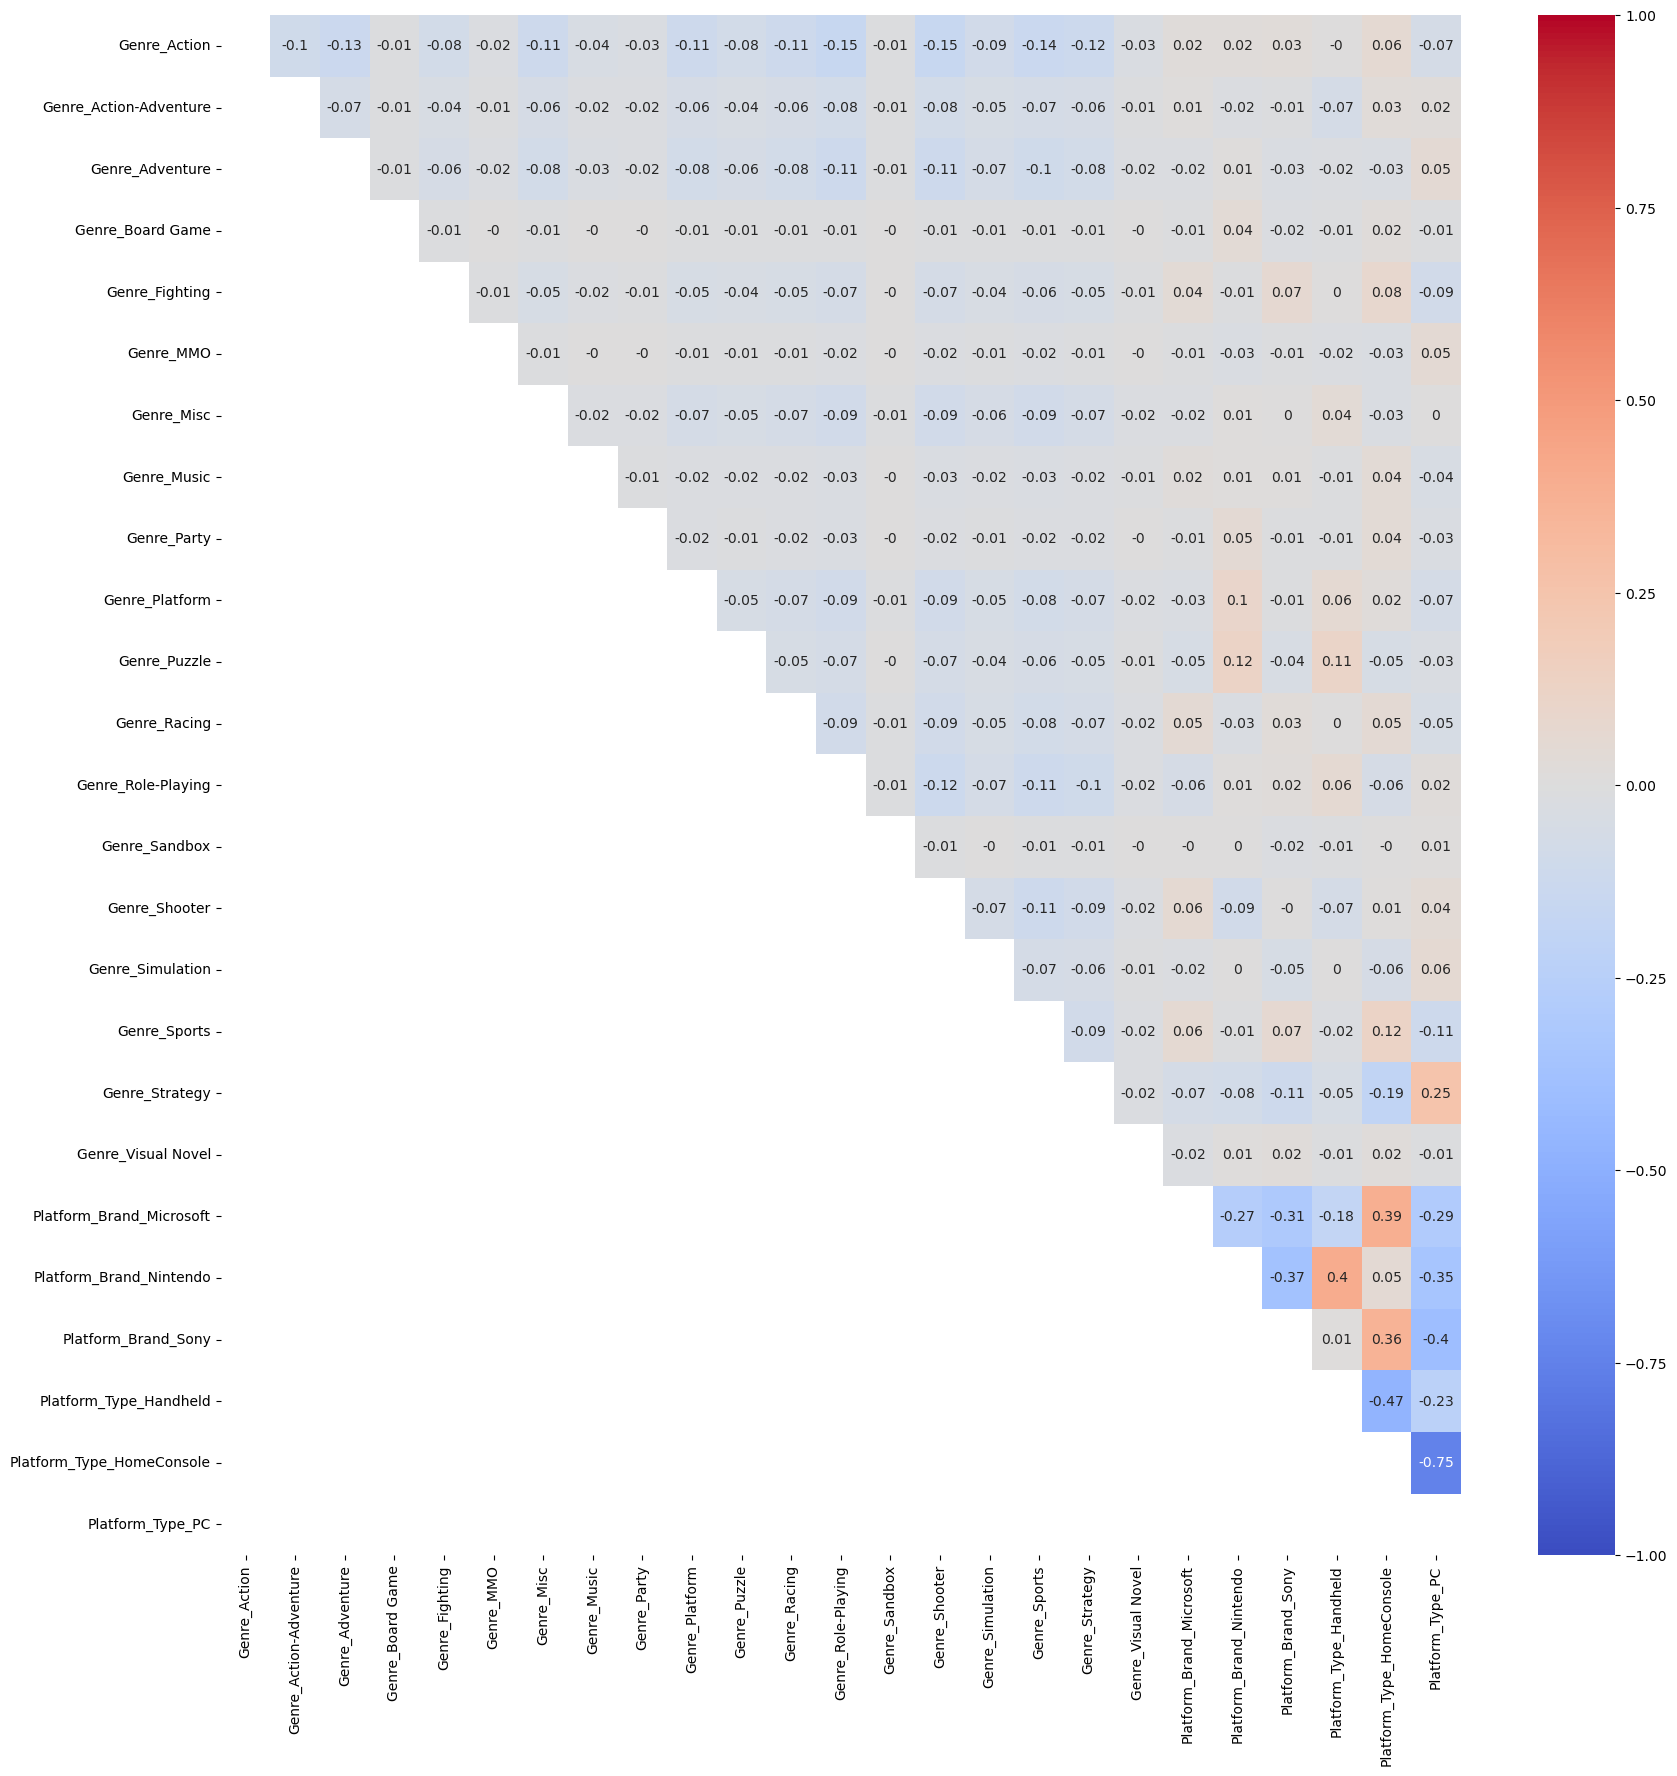

In [68]:
X_train_corr = X_train.drop(columns=["Name", "Publisher", "Developer", "Platform_Brand_PC"])
corr_df = X_train_corr.corr().round(2)

mask = np.tril(np.ones_like(corr_df))

plt.figure(figsize=(20,20))
sns.heatmap(corr_df, cmap='coolwarm', vmin=-1, vmax=1, annot=True, mask = mask)
plt.show()

In [69]:
X_train.drop(["Platform_Brand_PC"], axis = 1, inplace=True)
X_test.drop(["Platform_Brand_PC"], axis = 1, inplace=True)

In [70]:
# sanity check with all the dfs

print(X_train_numerical.shape)
print(X_train_dummy.shape)
print(X_test_numerical.shape)
print(X_test_dummy.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())

(10783, 3)
(10783, 26)
(3595, 3)
(3595, 26)
(10783, 28)
(3595, 28)
0
0


In [71]:
# checking the columns

X_train.columns

Index(['Name', 'Publisher', 'Developer', 'Genre_Action',
       'Genre_Action-Adventure', 'Genre_Adventure', 'Genre_Board Game',
       'Genre_Fighting', 'Genre_MMO', 'Genre_Misc', 'Genre_Music',
       'Genre_Party', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Sandbox', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy',
       'Genre_Visual Novel', 'Platform_Brand_Microsoft',
       'Platform_Brand_Nintendo', 'Platform_Brand_Sony',
       'Platform_Type_Handheld', 'Platform_Type_HomeConsole',
       'Platform_Type_PC'],
      dtype='object')

I think that using a NLP is a good idea, so I will use TF IDF to create more features. Then, I will be able to continue the processing.

<div id="heading--3-4"/>

## 3.4 - Columns to vectorize with TFDIF

Before vectorizing, I will create a my_tokenizer function to tokenize properly some columns

In [72]:
stemmer = nltk.stem.PorterStemmer()

ENGLISH_STOP_WORDS = stopwords.words('english')

# Custom stopwords to be added

custom_stopwords = []
custom_stopwords = ['game', 'games', 'unknown', 'studio', 'inc', 'ltd', 'studios']

# Extend stopwords with custom stopwords
ENGLISH_STOP_WORDS.extend(custom_stopwords)

# my_tokenizer function, to be used when vectorizing
def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

Now, I will vectorize 3 columns: Name, Publisher and Developer.

Under the code, I will also create histograms to show the 20 most weighted words in each column.

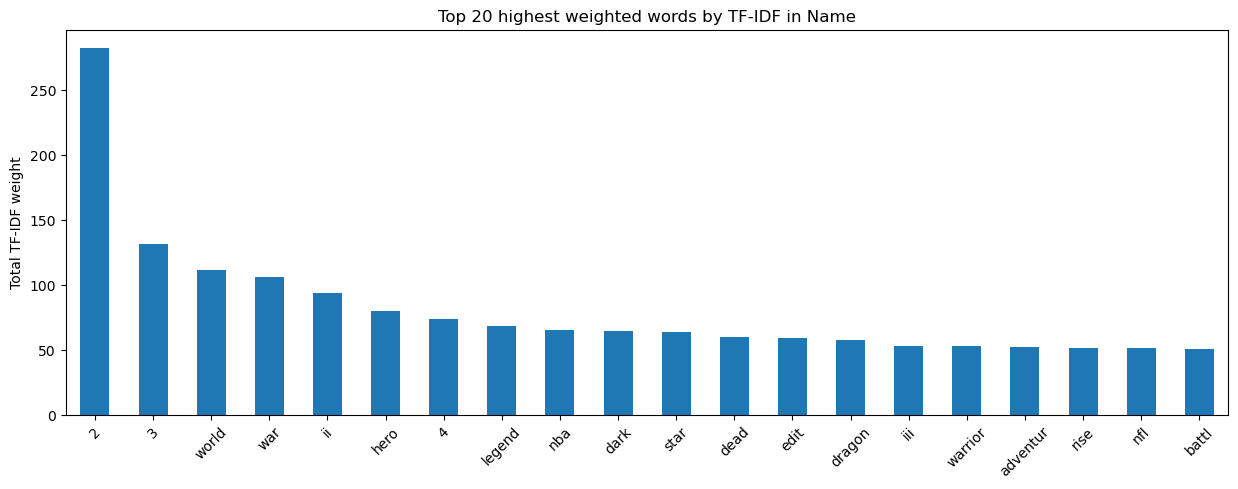

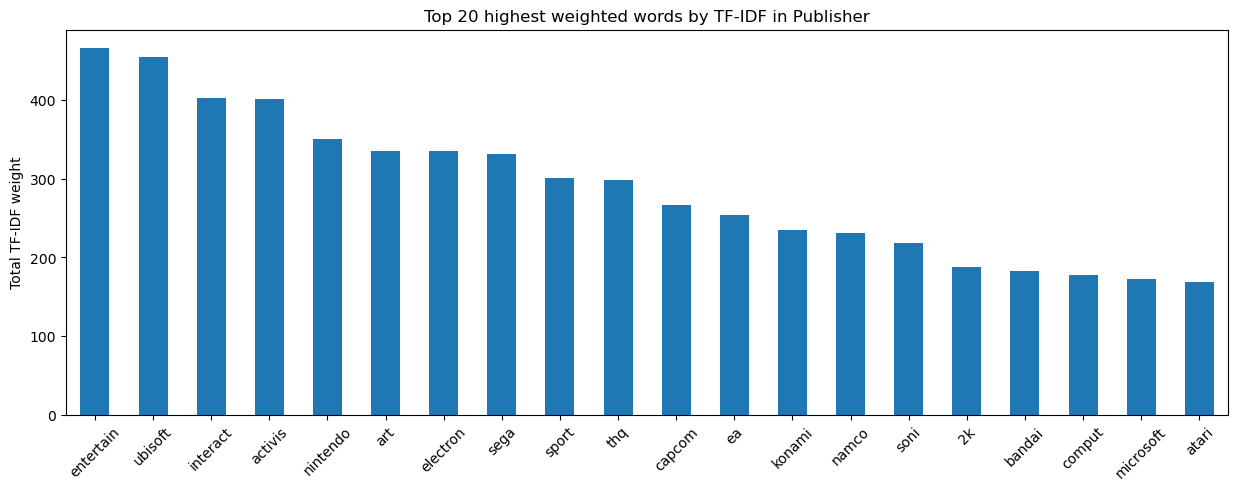

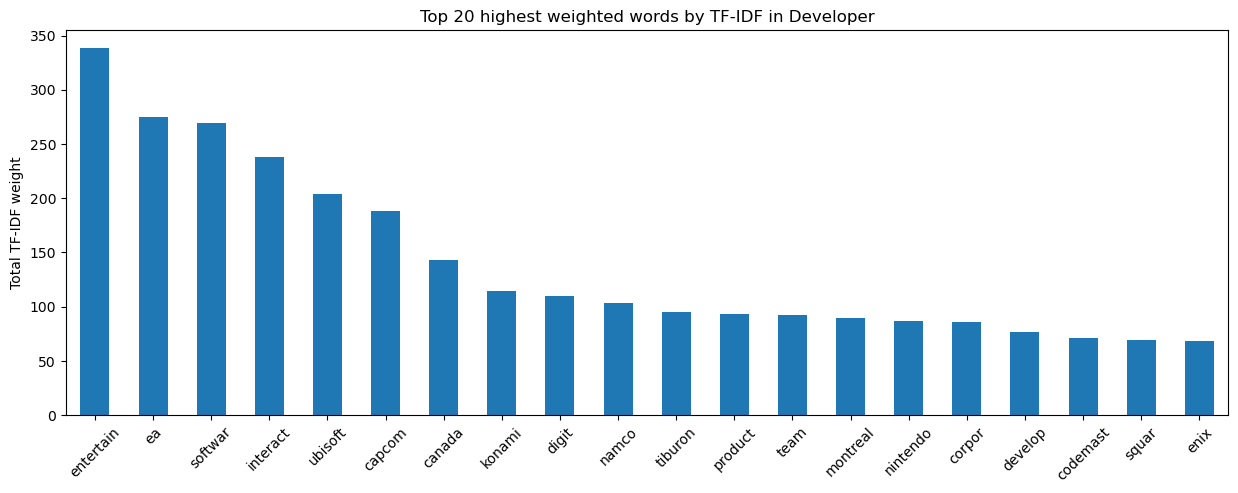

0
0
(10783, 2893)
(3595, 2893)


In [73]:
tfidf_columns = ['Name', 'Publisher', 'Developer']
tfidf_columns_variables = ['tfidf_Name', 'tfidf_Publisher', 'tfidf_Developer']


tfidf_dfs = []
X_train_keep = pd.DataFrame()

for i, col in enumerate(tfidf_columns):

    globals()[tfidf_columns_variables[i]] = TfidfVectorizer(tokenizer = my_tokenizer, min_df=4)

    # Fit and transform the text data
    transformed_train = globals()[tfidf_columns_variables[i]].fit_transform(X_train[col])
    transformed_test = globals()[tfidf_columns_variables[i]].transform(X_test[col])
    
    # store my vectorizers
    tfidf_dfs.append(globals()[tfidf_columns_variables[i]])

    # Convert the transformed data into a dataframe
    tfidf_df_train = pd.DataFrame(transformed_train.toarray(),
                                   columns=globals()[tfidf_columns_variables[i]].get_feature_names_out())

    tfidf_df_test = pd.DataFrame(transformed_test.toarray(),
                                   columns=globals()[tfidf_columns_variables[i]].get_feature_names_out())


    # Join the 2 tfidf_df with the 2 dfs
    tfidf_df_train = tfidf_df_train.add_prefix(f'{col}_')
    tfidf_df_test = tfidf_df_test.add_prefix(f'{col}_')
    X_train = pd.concat([X_train, tfidf_df_train], axis="columns")
    X_test = pd.concat([X_test, tfidf_df_test], axis="columns")
    
    X_train_keep[col] = X_train[col]
    
    X_train.drop(col, axis = 1, inplace=True)
    X_test.drop(col, axis = 1, inplace=True)
    
    word_counts = pd.DataFrame(
        {"counts": transformed_train.toarray().sum(axis=0)},
        index=globals()[tfidf_columns_variables[i]].get_feature_names_out()
    ).sort_values("counts", ascending=False)

    word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title(f"Top 20 highest weighted words by TF-IDF in {col}")
    plt.ylabel("Total TF-IDF weight")
    plt.xticks(rotation=45)
    plt.show()
    

# checking for null values and the shapes
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(X_train.shape)
print(X_test.shape)

In [74]:
# sanity check

X_train.head()

,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Board Game,Genre_Fighting,Genre_MMO,Genre_Misc,Genre_Music,Genre_Party,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Sandbox,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Genre_Visual Novel,Platform_Brand_Microsoft,Platform_Brand_Nintendo,Platform_Brand_Sony,Platform_Type_Handheld,Platform_Type_HomeConsole,Platform_Type_PC,...,Developer_way,Developer_wayforward,Developer_webfoot,Developer_westwood,Developer_white,Developer_wideload,Developer_wild,Developer_wildcard,Developer_wish,Developer_work,Developer_world,Developer_wow,Developer_x,Developer_xpec,Developer_yacht,Developer_yager,Developer_young,Developer_yuke,Developer_zaxi,Developer_zen,Developer_zenimax,Developer_zero,Developer_zipper,Developer_zoe,Developer_zoink
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10783 entries, 0 to 10782
Columns: 2893 entries, Genre_Action to Developer_zoink
dtypes: float64(2868), int32(25)
memory usage: 237.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595 entries, 0 to 3594
Columns: 2893 entries, Genre_Action to Developer_zoink
dtypes: float64(2868), int32(25)
memory usage: 79.0 MB
None


Before modeling, dropping one last column:


<div id="heading--3-5"/>

## 3.5 - Variance Threshold


With the variance threshold, I will only keep values that have a variance over the threshold. This way, all the columns that I don't need can be removed.

In [76]:
# sanity check to confirm the number of columns

print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10783 entries, 0 to 10782
Columns: 2893 entries, Genre_Action to Developer_zoink
dtypes: float64(2868), int32(25)
memory usage: 237.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595 entries, 0 to 3594
Columns: 2893 entries, Genre_Action to Developer_zoink
dtypes: float64(2868), int32(25)
memory usage: 79.0 MB
None


Because I removed a lot of columns, it created duplicated rows. So I will check where they are and remove them in both the X and y, train and test dfs.

In [77]:
# checking the number of duplicated rows

print(X_train.duplicated().sum())
print(X_test.duplicated().sum())

419
80


In [78]:
# dropping the duplicated rows on all the dfs

# list of indices of the duplicated rows in X_train
duplicate_indices = X_train[X_train.duplicated()].index

# Remove duplicate rows from X_train
X_train = X_train.drop_duplicates()

# Remove corresponding rows from y_train
y_train = y_train.drop(index=duplicate_indices)


# list of indices of the duplicated rows in X_test
duplicate_indices = X_test[X_test.duplicated()].index

# Remove duplicate rows from X_test
X_test = X_test.drop_duplicates()

# Remove corresponding rows from y_test
y_test = y_test.drop(index=duplicate_indices)

In [79]:
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(X_train.shape)
print(X_test.shape)

0
0
(10364, 2893)
(3515, 2893)


<div id="heading--4"/>

## 4. Part 4 - Modeling

<br>

I will start the modeling with different models at first.

I will also store the test scores in the df_scores dataframe.

### This part is still under construction. Some cells are work in progress.

In [80]:
# instantiating df_scores to store scores

df_scores=pd.DataFrame(columns=['score'])

df_scores

,score


In [81]:
# Split the data into remainder and test sets
X_rem_logit, X_test_logit, y_rem_logit, y_test_logit = train_test_split(X_train, y_train, test_size=0.3, random_state=26, stratify=y_train)

# Split the remainder set into train and validation sets
X_train_logit, X_val_logit, y_train_logit, y_val_logit = train_test_split(X_rem_logit, y_rem_logit, test_size=0.2, random_state=96, stratify=y_rem_logit)

# Print info on how the data has been split
print(f'The TRAIN set has {len(X_train_logit)} data points.')
print(f'The VALIDATION set has {len(X_val_logit)} data points.')
print(f'The TEST set has {len(X_test_logit)} data points.')

The TRAIN set has 5803 data points.
The VALIDATION set has 1451 data points.
The TEST set has 3110 data points.


In [82]:
%%time

# Baseline logistic regression

# Instantiate and fit to the train
baseline_logreg = LogisticRegression(max_iter = 10000, n_jobs=-1).fit(X_rem_logit, y_rem_logit)


# Print the accuracies
print(f'Accuracy on test set: {baseline_logreg.score(X_test_logit, y_test_logit)}')

df_scores.loc[f"Baseline log reg : C={baseline_logreg.get_params()['C']}"]=round(baseline_logreg.score(X_test_logit, y_test_logit),3)
df_scores

Accuracy on test set: 0.5540192926045016
CPU times: user 718 ms, sys: 316 ms, total: 1.03 s
Wall time: 11.8 s


,score
Baseline log reg : C=1.0,0.554


In [577]:
%%time

# Let's try a modest range of C values
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Set up empty lists
train_accuracies = []
validation_accuracies = []

# Iterate over the C values
for value in c_values:

    # Instantiate a log reg and fit to the train set
    logreg = LogisticRegression(C=value, random_state=1).fit(X_train_logit, y_train_logit)

    # Score on the train set and append this accuracy to its respective list
    train_accuracies.append(logreg.score(X_train_logit, y_train_logit))
    
    # Score on the validation set and append this accuracy to its respective list
    validation_accuracies.append(logreg.score(X_val_logit, y_val_logit))    

CPU times: user 2min 31s, sys: 18 s, total: 2min 49s
Wall time: 27.7 s


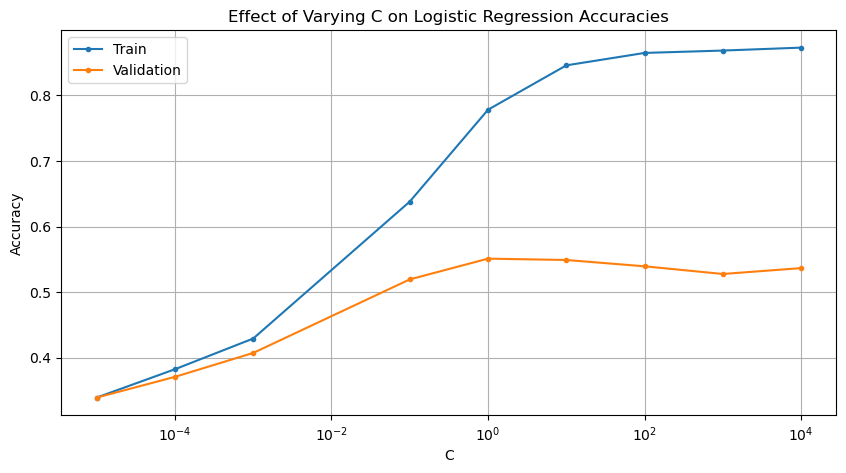

In [578]:
# Create a dataframe
scores_df=pd.DataFrame({'C value': c_values, 'train accuracy': train_accuracies, 'validation accuracy': validation_accuracies})

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, train_accuracies, label='Train', marker='.')
plt.plot(c_values, validation_accuracies, label='Validation', marker='.')
plt.legend()
plt.title('Effect of Varying C on Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [579]:
# best_c=c_values[np.argmax(validation_accuracies)]
# best_c

best_c = 1

In [580]:
# Instantiate a log reg and fit to the remainder set
validated_logreg = LogisticRegression(C=best_c, random_state=1).fit(X_rem_logit, y_rem_logit)

# Print the test accuracy
print(f'Accuracy on test set: {validated_logreg.score(X_test_logit, y_test_logit)}')

Accuracy on test set: 0.5564127290260367


In [581]:
df_scores.loc[f"One-Fold : C={validated_logreg.get_params()['C']}"]=round(validated_logreg.score(X_test_logit, y_test_logit),3)
df_scores

,score
Baseline log reg : C=1.0,0.557
One-Fold : C=1,0.556


In [582]:
%%time

# This is the same range of C values that I used before
c_values = [.00001, .0001, .001, 0.01, .1, 1, 10, 100, 1000, 10000]

# Set up an empty list
cv_accuracies = []

# Iterate over the C values
for value in c_values:

    # Instantiate a log reg
    logreg = LogisticRegression(C=value, random_state=11, n_jobs=-1, max_iter=20000)

    # Pass the model and the remainder set into the cross-validation function, then get cross-validated accuracy by taking the mean
    cv_accuracy = np.mean(cross_val_score(logreg, X_rem_logit, y_rem_logit, cv=5, n_jobs=-1))

    # Append the cross-validated accuracy to the list set up above
    cv_accuracies.append(cv_accuracy)

    # Print something at the end of each iteration
    print(f'For a C value of {value}, the cross-validated accuracy is {round(cv_accuracy, 6)}')

For a C value of 1e-05, the cross-validated accuracy is 0.338892
For a C value of 0.0001, the cross-validated accuracy is 0.374311
For a C value of 0.001, the cross-validated accuracy is 0.403805
For a C value of 0.01, the cross-validated accuracy is 0.458792
For a C value of 0.1, the cross-validated accuracy is 0.525083
For a C value of 1, the cross-validated accuracy is 0.559121
For a C value of 10, the cross-validated accuracy is 0.558158
For a C value of 100, the cross-validated accuracy is 0.551818
For a C value of 1000, the cross-validated accuracy is 0.542584


python(19010) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19011) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19013) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


For a C value of 10000, the cross-validated accuracy is 0.533075
CPU times: user 1.4 s, sys: 2.35 s, total: 3.75 s
Wall time: 17min 57s


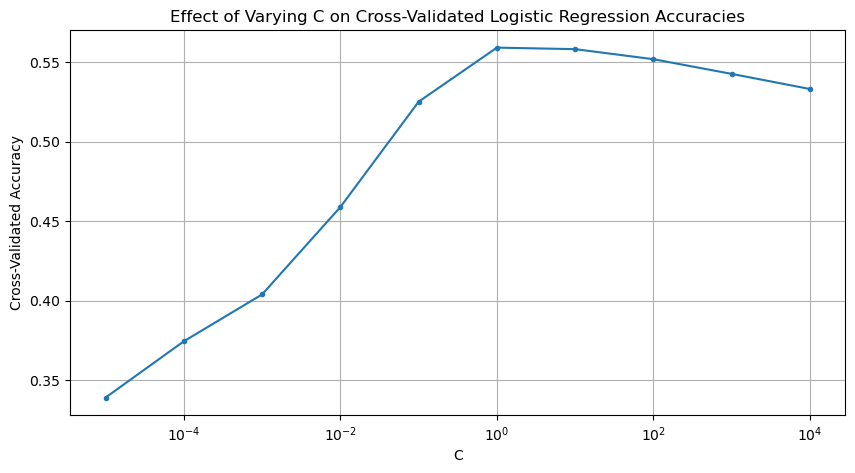

In [583]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, cv_accuracies, marker = '.')
plt.title('Effect of Varying C on Cross-Validated Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()

In [584]:
# Instantiate a log reg and fit to the remainder set
cross_validated_logreg = LogisticRegression(C=1, random_state=11).fit(X_rem_logit, y_rem_logit)

# Print the accuracies
print(f'Accuracy on remainder set: {cross_validated_logreg.score(X_rem_logit, y_rem_logit)}')
print(f'Accuracy on test set: {cross_validated_logreg.score(X_test_logit, y_test_logit)}')

Accuracy on remainder set: 0.7615766262403528
Accuracy on test set: 0.5564127290260367


In [585]:
df_scores.loc[f"5-Fold : C={cross_validated_logreg.get_params()['C']}"]=round(cross_validated_logreg.score(X_test_logit, y_test_logit),3)
df_scores

,score
Baseline log reg : C=1.0,0.557
One-Fold : C=1,0.556
5-Fold : C=1,0.556


In [303]:
# # Set up a directory to cache the pipeline results - if the same step with the same parameters is called again,
# # the cached result is used instead of re-computing it.
# cachedir = mkdtemp()

# # Set up a pipeline
# # The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
# my_pipeline = Pipeline(steps=[
#                         ('scaler', StandardScaler()),
#                         ('dim_reducer', PCA()),
#                         ('model', LogisticRegression())],
#                         memory=cachedir)

In [304]:
# # testing the first pipeline

# pipeline_test=my_pipeline.fit(X_train,y_train)
# pipeline_test

Pipeline(memory='/var/folders/78/w0cjxhcs0bs0nxt9vj1kv61m0000gn/T/tmpa0k0277e',
         steps=[('scaler', StandardScaler()), ('dim_reducer', PCA()),
                ('model', LogisticRegression())])

In [305]:
# storing the pipeline_test score in the df_scores

pipeline_test.score(X_test,y_test)
df_scores.loc[f"pipeline_test: "]=round(baseline_logreg.score(X_test, y_test),3)

In [419]:
# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler to the training data and transform the training data
# X_train = scaler.fit_transform(X_train)

# # Transform the test data using the scaler fitted on the training data
# X_test = scaler.transform(X_test)


In [83]:
# work in progress

# 1. Instantiate model
videogames_rfc = RandomForestClassifier(max_depth = 5, max_features = 1000)

# 2. Fit model
videogames_rfc.fit(X_train, y_train);


print(f'Score on train: {videogames_rfc.score(X_train, y_train)}')
print(f'Score on test: {videogames_rfc.score(X_test, y_test)}')

df_scores.loc[f"RandomForestClassifier: "]=round(videogames_rfc.score(X_test, y_test),3)

Score on train: 0.468448475492088
Score on test: 0.4332859174964438


In [384]:
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.fit_transform(y_test)

# print(y_train)
# print(y_test)
# print(y_train_encoded)
# print(y_test_encoded)
# y_train

0          Weak
1          Okay
2          Weak
3          Okay
4        Strong
          ...  
10778      Weak
10779      Weak
10780      Okay
10781    Strong
10782      Okay
Name: Metascore_Range, Length: 10286, dtype: object
0         Weak
1       Strong
2         Weak
3         Okay
4         Weak
         ...  
3590    Strong
3591      Okay
3592      Okay
3593    Strong
3594    Strong
Name: Metascore_Range, Length: 3486, dtype: object
[2 0 2 ... 0 1 0]
[2 1 2 ... 0 1 1]


0          Weak
1          Okay
2          Weak
3          Okay
4        Strong
          ...  
10778      Weak
10779      Weak
10780      Okay
10781    Strong
10782      Okay
Name: Metascore_Range, Length: 10286, dtype: object

In [387]:
print(y_train)

0          Weak
1          Okay
2          Weak
3          Okay
4        Strong
          ...  
10778      Weak
10779      Weak
10780      Okay
10781    Strong
10782      Okay
Name: Metascore_Range, Length: 10286, dtype: object


In [84]:
mapping_dict = {
    'Weak': 0,
    'Okay': 1,
    'Strong': 2
}

In [85]:


# Apply the mapping using the map() function
y_train = y_train.map(mapping_dict)
y_test = y_test.map(mapping_dict)


In [86]:
print(y_train)
print(y_test)
X_train

0        2
1        0
2        0
3        0
4        1
        ..
10775    1
10776    0
10777    0
10779    0
10780    2
Name: Metascore_Range, Length: 10364, dtype: int64
0       1
1       2
2       1
3       1
4       2
       ..
3589    2
3590    2
3591    1
3592    1
3594    1
Name: Metascore_Range, Length: 3515, dtype: int64


,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Board Game,Genre_Fighting,Genre_MMO,Genre_Misc,Genre_Music,Genre_Party,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Sandbox,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Genre_Visual Novel,Platform_Brand_Microsoft,Platform_Brand_Nintendo,Platform_Brand_Sony,Platform_Type_Handheld,Platform_Type_HomeConsole,Platform_Type_PC,...,Developer_way,Developer_wayforward,Developer_webfoot,Developer_westwood,Developer_white,Developer_wideload,Developer_wild,Developer_wildcard,Developer_wish,Developer_work,Developer_world,Developer_wow,Developer_x,Developer_xpec,Developer_yacht,Developer_yager,Developer_young,Developer_yuke,Developer_zaxi,Developer_zen,Developer_zenimax,Developer_zero,Developer_zipper,Developer_zoe,Developer_zoink
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10775,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10776,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10777,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10779,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
%%time

# testing a few different models, some have been optimized, some no
# work in progress

# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# y_test = label_encoder.fit_transform(y_test)

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_encoded,
#                                                     test_size=0.3, stratify = y_encoded)

xgb_model = XGBClassifier(colsample_bytree= 0.75,
                          learning_rate= 0.1, max_depth= 7,
                          n_estimators= 500, subsample= 1)
ab_model = AdaBoostClassifier()
rf_model = RandomForestClassifier(max_depth= 5, max_features= 'sqrt',
                                  min_samples_leaf= 1, min_samples_split= 10, n_estimators= 300)
nn_model = MLPClassifier(hidden_layer_sizes=(5,5,5,5))
dtc_model = DecisionTreeClassifier()
bag_model = BaggingClassifier()

xgb_model.fit(X_train, y_train)
ab_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)
dtc_model.fit(X_train, y_train)
bag_model.fit(X_train, y_train)


print("Scores:")
print(f"AdaBoost train score : {ab_model.score(X_train, y_train)}")
print(f"AdaBoost test score: {ab_model.score(X_test, y_test)}")
print(f"Random Forest train score: {rf_model.score(X_train, y_train)}")
print(f"Random Forest test score: {rf_model.score(X_test, y_test)}")
print(f"XG Boost train score: {xgb_model.score(X_train, y_train)}")
print(f"XG Boost test score: {xgb_model.score(X_test, y_test)}")
print(f"NN Boost train score: {nn_model.score(X_train, y_train)}")
print(f"NN Boost test score: {nn_model.score(X_test, y_test)}")
print(f"DecisionTreeClassifier train score: {dtc_model.score(X_train, y_train)}")
print(f"DecisionTreeClassifier test score: {dtc_model.score(X_test, y_test)}")
print(f"BaggingClassifier train score: {bag_model.score(X_train, y_train)}")
print(f"BaggingClassifier test score: {bag_model.score(X_test, y_test)}")



df_scores.loc[f"AdaBoost: "]=round(ab_model.score(X_test, y_test),3)
df_scores.loc[f"Random Forest: "]=round(rf_model.score(X_test, y_test),3)
df_scores.loc[f"XG Boost: "]=round(xgb_model.score(X_test, y_test),3)
df_scores.loc[f"NN Boost: "]=round(nn_model.score(X_test, y_test),3)
df_scores.loc[f"DecisionTreeClassifier: "]=round(dtc_model.score(X_test, y_test),3)
df_scores.loc[f"BaggingClassifier: "]=round(bag_model.score(X_test, y_test),3)

Scores:
AdaBoost train score : 0.47375530683133926
AdaBoost test score: 0.44950213371266
Random Forest train score: 0.4849478965650328
Random Forest test score: 0.4523470839260313
XG Boost train score: 0.763894249324585
XG Boost test score: 0.5581792318634424
NN Boost train score: 0.9266692396758008
NN Boost test score: 0.5266002844950214
DecisionTreeClassifier train score: 1.0
DecisionTreeClassifier test score: 0.4805120910384068
BaggingClassifier train score: 0.9758780393670398
BaggingClassifier test score: 0.5331436699857752
CPU times: user 15min 7s, sys: 3min 25s, total: 18min 33s
Wall time: 2min 54s


In [100]:
xgb_model = XGBClassifier(colsample_bytree= 0.75,
                          learning_rate= 0.1, max_depth= 9,
                          n_estimators= 3500, subsample= 1)

xgb_model.fit(X_train, y_train)

print(f"XG Boost train score: {xgb_model.score(X_train, y_train)}")
print(f"XG Boost test score: {xgb_model.score(X_test, y_test)}")

XG Boost train score: 0.9493438826707835
XG Boost test score: 0.6113798008534851


In [591]:
%%time

# work in progress, it takes a long time


param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [400, 500, 600],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Initialize GridSearchCV with the specified parameter grid and XGBoost model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters:", grid_search.best_params_)

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Evaluate the best model on the test data
accuracy = best_xgb_model.score(X_test, y_test)
print("Test accuracy of best model:", accuracy)

df_scores.loc[f"Best XGB Model: "]=round(best_xgb_model.score(X_test, y_test),3)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


python(19214) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19215) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19216) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19217) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19218) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19220) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19222) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19224) Malloc

KeyboardInterrupt: 

In [ ]:
%%time

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [1, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize Random Forest classifier
rf_model = RandomForestClassifier()

# Initialize GridSearchCV with the specified parameter grid and Random Forest model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters:", grid_search.best_params_)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test data
accuracy = best_rf_model.score(X_test, y_test)
print("Test accuracy of best model:", accuracy)

df_scores.loc[f"Best RF Model: "]=round(best_rf_model.score(X_test, y_test),3)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


python(21005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21006) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21008) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21010) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21011) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21013) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21015) Malloc

In [134]:
# work in progress, it takes a long time

# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
logreg_param_grid = [

    # l1 with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='saga',penalty='l1', random_state=1, n_jobs=-1, max_iter=1000)],
     'model__C': c_values},


    # l2 (default) with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l2',random_state=1, n_jobs=-1, max_iter=1000)],
     'model__C': c_values}
]

In [ ]:
%%time

# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=3)

# Fit the log reg grid search
logreg_gs.fit(X_train, y_train)

print(f"The best logistic regression's accuracy on the train set: {logreg_gs.score(X_train, y_train)}")
print(f"The best logistic regression's accuracy on the test set: {logreg_gs.score(X_test, y_test)}")

df_scores.loc[f"LogReg_GS Model: "]=round(logreg_gs.score(X_test, y_test),3)

<div id="heading--4-1"/>

## 4.1 - First Scores, some optimization

<br>

In [ ]:
# showing all the scores

df_scores


<div id="heading--4-2"/>

## 4.2 - Confusion Matrix

<br>

In [103]:
# quick test of confusion matrix

# Get class predictions
y_pred = xgb_model.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predict 1", "2", "3"],
    index=["True 1", "2", "3"]
)

display(cf_df)

,Predict 1,2,3
True 1,793,305,92
2,315,600,241
3,119,294,756


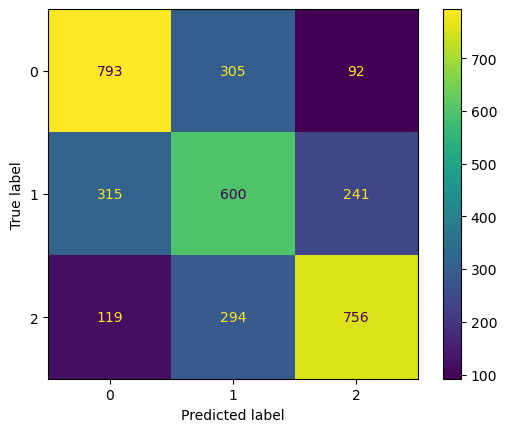

In [104]:
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test)

In [ ]:
print(f'The current best accuracy with XG Boost is : {round(xgb_model.score(X_test, y_test),3)}')

## The models are just a first draft of what it can do, I haven't optimized a lot yet.

## More to follow

In [101]:
import pickle

In [167]:
joblib.dump(xgb_model, "../Models/xgb_model.sav")

['../Models/xgb_model.sav']

In [102]:
print("creating pickle file")
pickle.dump(tfidf_Name,open('../Models/name.pkl','wb'))
pickle.dump(tfidf_Publisher,open('../Models/publisher.pkl','wb'))
pickle.dump(tfidf_Developer,open('../Models/developer.pkl','wb'))
pickle.dump(xgb_model,open('../Models/xgb_model.pkl','wb'))

creating pickle file
